# Intent Data Analysis
This notebook inspects the raw intent corpora powering the sticker selection model. It focuses on understanding label coverage, pruning noisy intents, and producing summary artefacts used during training.

## What you will find here
- Automatic project-path discovery so the notebook works from anywhere in the repo.
- Data ingestion for `telemarketing_intent_cn.jsonl` plus the optional `crosswoz.jsonl` corpus.
- Exploratory analysis (statistics, tables, charts) to inspect intent coverage and message length patterns.
- Filtering utilities (blacklist removal, minimum sample threshold, balanced sampling) to produce a clean dataset.
- Persistence of cleaned data and label reports under `assets/models/intent_predictor` for downstream notebooks.

In [13]:
from __future__ import annotations

import json
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

sns.set_theme(style="darkgrid", context="notebook")
plt.rcParams["figure.figsize"] = (11, 6)
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.family"] = ["Microsoft YaHei", "SimHei", "sans-serif"]

In [14]:
NOTEBOOK_DIR = Path().resolve()


def find_project_root(start: Path) -> Path:
    for candidate in [start] + list(start.parents):
        if (candidate / "assets" / "models").exists():
            return candidate
    raise RuntimeError("Could not find project root (missing assets/models)")


PROJECT_ROOT = find_project_root(NOTEBOOK_DIR)
ASSETS_DIR = PROJECT_ROOT / "assets"
MODELS_DIR = ASSETS_DIR / "models"
DATA_DIR = MODELS_DIR / "few_shot_intent_sft" / "data"
MODEL_DIR = MODELS_DIR / "intent_predictor"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

TELEMARKETING_DATA = DATA_DIR / "telemarketing_intent_cn.jsonl"
CROSSWOZ_DATA = DATA_DIR / "crosswoz.jsonl"

PROCESSED_DATA_PATH = MODEL_DIR / "clean_wechat_intents.parquet"
LABEL_COUNTS_PATH = MODEL_DIR / "label_distribution.csv"

RANDOM_SEED = 42
MIN_SAMPLES = 20
MAX_SAMPLES_PER_INTENT = 300
USE_CROSSWOZ = True

print(f"Project root: {PROJECT_ROOT}")
print(f"Raw data directory: {DATA_DIR}")
print(f"Artifacts will be stored in: {MODEL_DIR}")

Project root: D:\Files\Develop Projects\AI\Yuzuriha-Rin
Raw data directory: D:\Files\Develop Projects\AI\Yuzuriha-Rin\assets\models\few_shot_intent_sft\data
Artifacts will be stored in: D:\Files\Develop Projects\AI\Yuzuriha-Rin\assets\models\intent_predictor


In [15]:
BLACKLIST_INTENTS = {
    "查询类",
    "查询(产品信息)",
    "查询(价格)",
    "查询(优惠)",
    "查询(库存)",
    "查询(物流)",
    "查询(订单)",
    "查询(账户)",
    "查询(余额)",
    "实体(产品)",
    "实体(价格)",
    "实体(时间)",
    "实体(地点)",
    "实体(人名)",
    "实体(公司)",
    "实体识别",
    "产品推荐",
    "促销活动",
    "优惠信息",
    "下单",
    "支付",
    "退款",
    "投诉",
    "售后",
    "政治敏感",
    "污言秽语",
    "色情低俗",
    "暴力血腥",
    "违法犯罪",
    "广告营销",
    "诈骗信息",
    "肯定(没问题)",
    "否定(没有)",
    "转人工",
    "挂断电话",
    "保持通话",
    "重复",
    "澄清",
    "确认信息",
    "核实身份",
    "录音提示",
    "系统提示",
}

RAW_DATASETS = [
    ("telemarketing", TELEMARKETING_DATA),
    ("crosswoz", CROSSWOZ_DATA),
]


def read_jsonl(path: Path) -> pd.DataFrame:
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return pd.DataFrame(rows)


def load_raw_dataset() -> pd.DataFrame:
    frames = []
    for name, path in RAW_DATASETS:
        if not path.exists():
            print(f"Skipping {name}: {path} not found")
            continue
        df = read_jsonl(path)
        df["dataset"] = name
        frames.append(df)
    if not frames:
        raise FileNotFoundError(
            "No datasets available. Please place jsonl files in assets/models/few_shot_intent_sft/data"
        )
    merged = pd.concat(frames, ignore_index=True)
    merged = merged.rename(columns={"text": "text", "label": "label"})
    merged["text"] = merged["text"].astype(str)
    return merged


def apply_filters(df: pd.DataFrame) -> pd.DataFrame:
    filtered = df[~df["label"].isin(BLACKLIST_INTENTS)].copy()
    label_counts = filtered["label"].value_counts()
    keep_labels = label_counts[label_counts >= MIN_SAMPLES].index
    filtered = filtered[filtered["label"].isin(keep_labels)].copy()
    filtered["text_length"] = filtered["text"].str.len()
    return filtered


def balance_dataset(df: pd.DataFrame, max_samples: int) -> pd.DataFrame:
    balanced_parts = []
    for label, group in df.groupby("label"):
        if len(group) > max_samples:
            sample = group.sample(n=max_samples, random_state=RANDOM_SEED)
        else:
            sample = group
        balanced_parts.append(sample)
    balanced = pd.concat(balanced_parts, ignore_index=True)
    balanced = balanced.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(
        drop=True
    )
    balanced["text_length"] = balanced["text"].str.len()
    return balanced

In [16]:
raw_df = load_raw_dataset()
print(f"Loaded {len(raw_df):,} rows from {raw_df['dataset'].nunique()} datasets")
raw_df.head()

Loaded 20,279 rows from 2 datasets


,text,label,data_source,split,dataset
0,"哦,我考虑下",考虑一下,telemarketing_intent_cn,train,telemarketing
1,恩。哎再说吧我考虑一下hiahia,考虑一下,telemarketing_intent_cn,train,telemarketing
2,"好的,我会考虑的",考虑一下,telemarketing_intent_cn,train,telemarketing
3,让我考虑一下,考虑一下,telemarketing_intent_cn,train,telemarketing
4,"哎,再说吧,我再想想",考虑一下,telemarketing_intent_cn,train,telemarketing


In [17]:
raw_summary = (
    raw_df.groupby("dataset")
    .agg(samples=("text", "count"), unique_labels=("label", "nunique"))
    .sort_values("samples", ascending=False)
)
raw_summary

,samples,unique_labels
dataset,,
telemarketing,11710,92
crosswoz,8569,3


### Clean and balance the dataset
1. Remove intents on the blacklist that do not fit the WeChat chat use case.
2. Drop intents with fewer than `MIN_SAMPLES` examples.
3. Cap large classes to `MAX_SAMPLES_PER_INTENT` to avoid bias.
4. Shuffle to avoid unintentional ordering artifacts.

In [18]:
filtered_df = apply_filters(raw_df)
balanced_df = balance_dataset(filtered_df, MAX_SAMPLES_PER_INTENT)

print(
    f"Filtered dataset: {len(filtered_df):,} rows · {filtered_df['label'].nunique()} intents"
)
print(
    f"Balanced dataset: {len(balanced_df):,} rows · {balanced_df['label'].nunique()} intents"
)

balanced_df.head()

Filtered dataset: 19,149 rows · 73 intents
Balanced dataset: 10,140 rows · 73 intents


,text,label,data_source,split,dataset,text_length
0,晚点马上还,会按时处理,telemarketing_intent_cn,train,telemarketing,5
1,都不要,否定(不需要),telemarketing_intent_cn,test,telemarketing,3
2,到底多少钱,疑问(数值),telemarketing_intent_cn,train,telemarketing,5
3,下个月再还,答时间,telemarketing_intent_cn,train,telemarketing,5
4,还在嘛,你还在吗,telemarketing_intent_cn,train,telemarketing,3


In [19]:
intent_counts = balanced_df["label"].value_counts()
length_stats = balanced_df["text_length"].describe()

print("Length (chars) stats:")
print(length_stats)

intent_counts.head(10)

Length (chars) stats:
count    10140.000000
mean         7.398718
std          7.566472
min          1.000000
25%          4.000000
50%          5.000000
75%          8.000000
max         71.000000
Name: text_length, dtype: float64


label
答时间        300
不信任        300
查联系方式      300
thank      300
肯定(知道了)    300
greet      300
语气词        300
肯定(好的)     300
查收费方式      300
否定答复       300
Name: count, dtype: int64

### Label distribution (top 30 intents)
The bar plot highlights the top intents after filtering and balancing.

C:\Users\Leever\AppData\Local\Temp\ipykernel_39640\679822771.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_series.values, y=plot_series.index, palette="viridis")


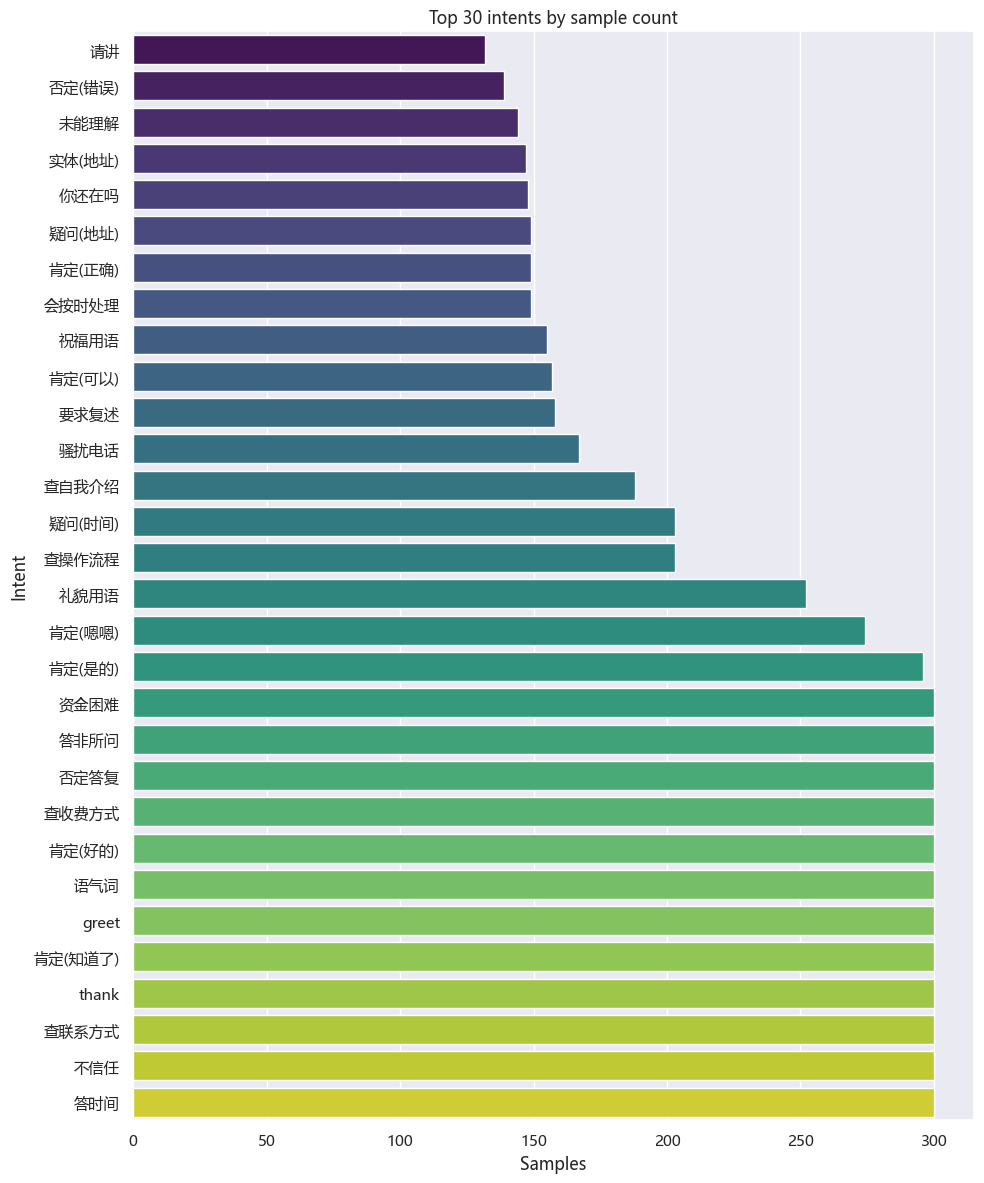

In [20]:
top_n = 30
plot_series = intent_counts.head(top_n)[::-1]
plt.figure(figsize=(10, 12))
sns.barplot(x=plot_series.values, y=plot_series.index, palette="viridis")
plt.title(f"Top {top_n} intents by sample count")
plt.xlabel("Samples")
plt.ylabel("Intent")
plt.tight_layout()
plt.show()

### Text length overview
Character-length histograms and per-dataset box plots help us understand complexity and tailor truncation length.

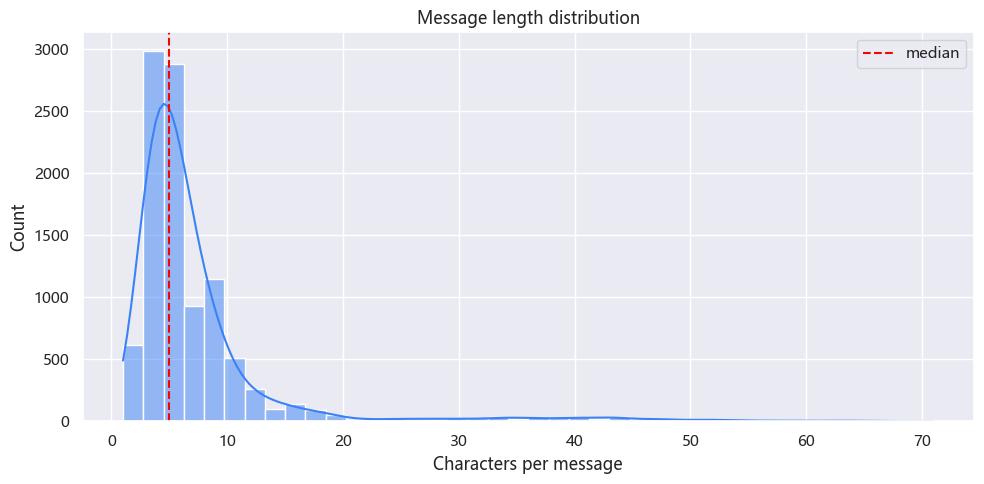

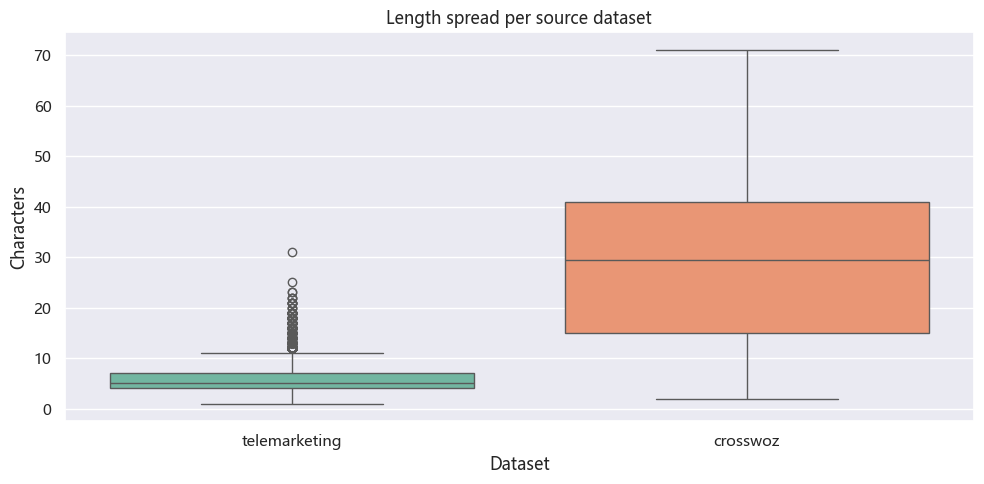

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(balanced_df["text_length"], bins=40, kde=True, color="#3b82f6")  # type: ignore
plt.axvline(
    balanced_df["text_length"].median(), color="red", linestyle="--", label="median"
)
plt.title("Message length distribution")
plt.xlabel("Characters per message")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=balanced_df, x="dataset", y="text_length", palette="Set2", hue="dataset"
)
plt.title("Length spread per source dataset")
plt.xlabel("Dataset")
plt.ylabel("Characters")
plt.tight_layout()
plt.show()

### Dataset vs intent heatmap
The heatmap highlights which intents originate from which dataset, revealing potential coverage gaps.

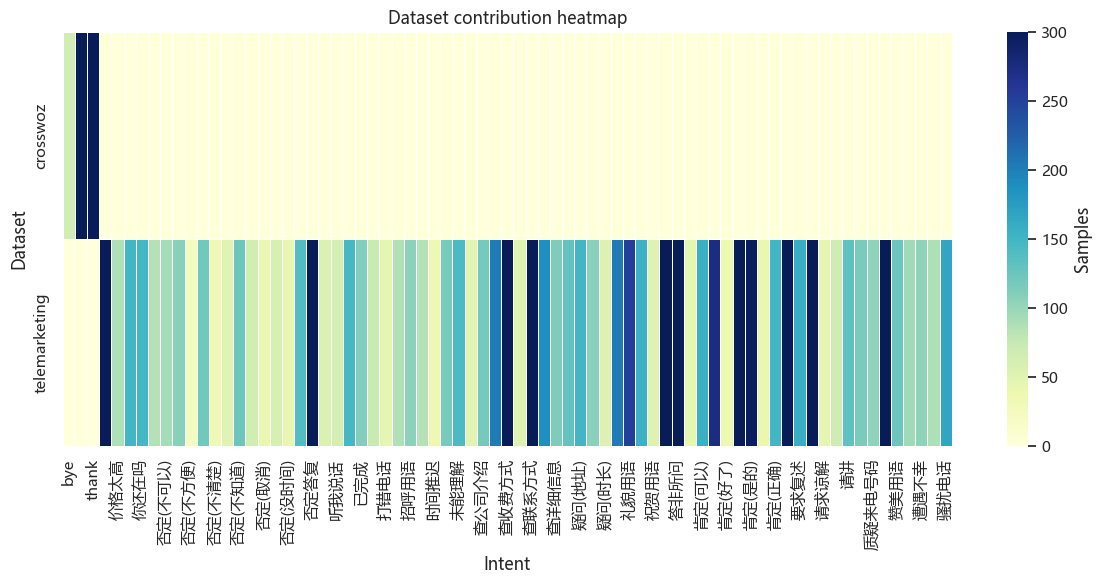

In [22]:
pivot = balanced_df.groupby(["dataset", "label"]).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot,
    cmap="YlGnBu",
    cbar_kws={"label": "Samples"},
    linewidths=0.5,
)
plt.title("Dataset contribution heatmap")
plt.xlabel("Intent")
plt.ylabel("Dataset")
plt.tight_layout()
plt.show()

### Persist processed data for reuse
Saving the balanced dataset speeds up repeated experiments and keeps `assets/models/intent_predictor` self-contained.

In [23]:
balanced_df.to_parquet(PROCESSED_DATA_PATH, index=False)
intent_counts.to_csv(LABEL_COUNTS_PATH, header=["samples"])

print(f"Processed dataset saved to: {PROCESSED_DATA_PATH}")
print(f"Label distribution saved to: {LABEL_COUNTS_PATH}")
print(f"Timestamp: {datetime.utcnow().isoformat()}Z")

Processed dataset saved to: D:\Files\Develop Projects\AI\Yuzuriha-Rin\assets\models\intent_predictor\clean_wechat_intents.parquet
Label distribution saved to: D:\Files\Develop Projects\AI\Yuzuriha-Rin\assets\models\intent_predictor\label_distribution.csv
Timestamp: 2025-12-16T09:49:54.819645Z


### Quick samples
Use this cell to inspect a few random rows whenever you re-run the notebook.

In [24]:
balanced_df.sample(5, random_state=RANDOM_SEED)

,text,label,data_source,split,dataset,text_length
1107,"这个都不清楚吗,笨",否定(不清楚),telemarketing_intent_cn,train,telemarketing,9
2039,喔耶,语气词,telemarketing_intent_cn,train,telemarketing,2
5396,知道啊,肯定(知道了),telemarketing_intent_cn,train,telemarketing,3
6167,"哦,知道了。你的什么邮箱？",肯定(知道了),telemarketing_intent_cn,train,telemarketing,13
1330,"好吧,拜拜喽",结束用语,telemarketing_intent_cn,train,telemarketing,6
